In [2]:
def remove_newlines(serie):
    serie = serie.str.replace('\n', ' ')
    serie = serie.str.replace('\\n', ' ')
    serie = serie.str.replace('  ', ' ')
    serie = serie.str.replace('  ', ' ')
    return serie

In [3]:
import pandas as pd
import os

#load data
parent_dir = os.path.dirname(os.getcwd())
file_path = os.path.join(parent_dir, 'INPUT/central_bank_speech/all_speeches.csv')
data = pd.read_csv(file_path)

# Set the text column to be the raw text with the newlines removed
# read speech which coutry is united states
df = data[(data["country"] == "united states")]
df['text'] = remove_newlines(df.text)
df.head()

/var/folders/q_/2syhc8zd0bzd52v4kv8xp4g80000gq/T/ipykernel_7680/2931785837.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  serie = serie.str.replace('\\n', ' ')
/var/folders/q_/2syhc8zd0bzd52v4kv8xp4g80000gq/T/ipykernel_7680/2230316549.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['text'] = remove_newlines(df.text)


,reference,country,date,title,author,is_gov,text
6139,r970105a_FOMC,united states,5/1/1997,I. Structural Models and Monetary Policy Analysis,meyer,0,I am in the middle of my third interesting and...
6140,r970114a_FOMC,united states,14/1/1997,National Bank of Belgium,greenspan,1,"Mr. Prime Minister, Minister of Finance, Minis..."
6141,r970116a_FOMC,united states,16/1/1997,Balanced Risks Going Forward,meyer,0,Measured on a fourth quarter to fourth quarter...
6142,r970124a_FOMC,united states,24/1/1997,Activities,meyer,0,My topic this morning is financial modernizati...
6143,r970128a_FOMC,united states,28/1/1997,should,phillips,0,Good afternoon. It is a pleasure to be here to...


/var/folders/q_/2syhc8zd0bzd52v4kv8xp4g80000gq/T/ipykernel_7680/517038113.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['n_tokens'] = df.text.apply(lambda x: len(tokenizer.encode(x)))


<AxesSubplot:>

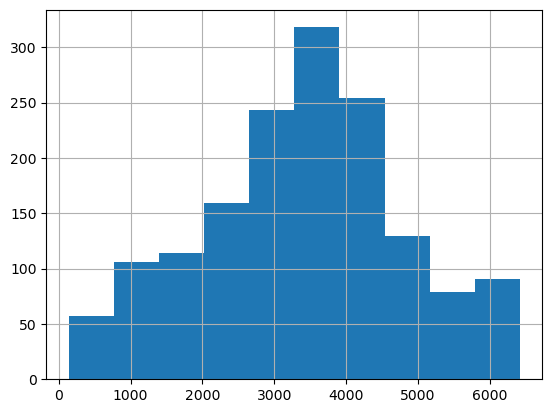

In [4]:
import tiktoken

# Load the cl100k_base tokenizer which is designed to work with the ada-002 model
tokenizer = tiktoken.get_encoding("cl100k_base")

# Tokenize the text and save the number of tokens to a new column
df['n_tokens'] = df.text.apply(lambda x: len(tokenizer.encode(x)))

# Visualize the distribution of the number of tokens per row using a histogram
df.n_tokens.hist()

In [10]:
#MODEL NAME	              TOKENIZER	      MAX INPUT TOKENS	  OUTPUT DIMENSIONS
#text-embedding-ada-002	  cl100k_base	  8191	              1536

In [7]:
#import openai

#df['embeddings'] = df.text.apply(lambda x: openai.Embedding.create(input=x, engine='text-embedding-ada-002')['data'][0]['embedding'])
df.to_csv('embeddings_us.csv')
df.head()

,reference,country,date,title,author,is_gov,text,n_tokens,embeddings
6139,r970105a_FOMC,united states,5/1/1997,I. Structural Models and Monetary Policy Analysis,meyer,0,I am in the middle of my third interesting and...,3672,"[-0.024781599640846252, 0.003763307584449649, ..."
6140,r970114a_FOMC,united states,14/1/1997,National Bank of Belgium,greenspan,1,"Mr. Prime Minister, Minister of Finance, Minis...",5717,"[-0.014163888059556484, -0.017375079914927483,..."
6141,r970116a_FOMC,united states,16/1/1997,Balanced Risks Going Forward,meyer,0,Measured on a fourth quarter to fourth quarter...,4915,"[-0.02128002792596817, -0.02292000502347946, 0..."
6142,r970124a_FOMC,united states,24/1/1997,Activities,meyer,0,My topic this morning is financial modernizati...,5260,"[-0.020877256989479065, -0.023576321080327034,..."
6143,r970128a_FOMC,united states,28/1/1997,should,phillips,0,Good afternoon. It is a pleasure to be here to...,3167,"[-0.0017014129552990198, -0.010241386480629444..."


In [ ]:
### skip this part
### can be used to split speech into paragraphs

max_tokens = 500

# Function to split the text into chunks of a maximum number of tokens
def split_into_many(text, max_tokens = max_tokens):

    # Split the text into sentences
    sentences = text.split('. ')

    # Get the number of tokens for each sentence
    n_tokens = [len(tokenizer.encode(" " + sentence)) for sentence in sentences]
    
    chunks = []
    tokens_so_far = 0
    chunk = []

    # Loop through the sentences and tokens joined together in a tuple
    for sentence, token in zip(sentences, n_tokens):

        # If the number of tokens so far plus the number of tokens in the current sentence is greater 
        # than the max number of tokens, then add the chunk to the list of chunks and reset
        # the chunk and tokens so far
        if tokens_so_far + token > max_tokens:
            chunks.append(". ".join(chunk) + ".")
            chunk = []
            tokens_so_far = 0

        # If the number of tokens in the current sentence is greater than the max number of 
        # tokens, go to the next sentence
        if token > max_tokens:
            continue

        # Otherwise, add the sentence to the chunk and add the number of tokens to the total
        chunk.append(sentence)
        tokens_so_far += token + 1

    return chunks
    

shortened = []

# Loop through the dataframe
for row in df.iterrows():

    # If the text is None, go to the next row
    if row[1]['text'] is None:
        continue

    # If the number of tokens is greater than the max number of tokens, split the text into chunks
    if row[1]['n_tokens'] > max_tokens:
        shortened += split_into_many(row[1]['text'])
    
    # Otherwise, add the text to the list of shortened texts
    else:
        shortened.append( row[1]['text'] )


df = pd.DataFrame(shortened, columns = ['text'])
df['n_tokens'] = df.text.apply(lambda x: len(tokenizer.encode(x)))
df.n_tokens.hist()

<AxesSubplot:>

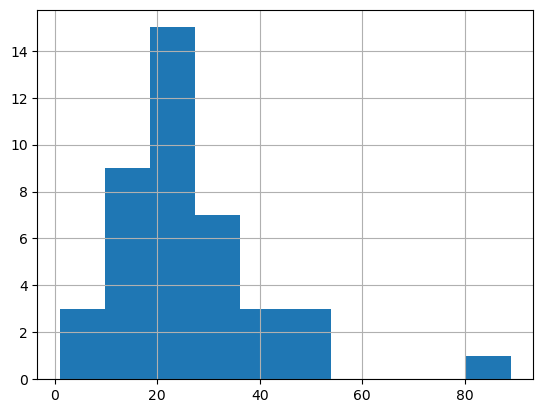

In [15]:
# select one speech and create a QA model for it
#bowman20221020
speech = df.tail(1)

# split the speech into sentences
sentences = speech.text.str.split('.').tolist()[0]
# remove the lastsentence which is empty
sentences = sentences[:-1]
# create a dataframe with the sentences
df_sentences = pd.DataFrame(sentences, columns = ['sentence'])
df_sentences['n_tokens'] = df_sentences.sentence.apply(lambda x: len(tokenizer.encode(x)))
df_sentences.n_tokens.hist()

In [17]:
df_sentences['embeddings'] = df_sentences.sentence.apply(lambda x: openai.Embedding.create(input=x, engine='text-embedding-ada-002')['data'][0]['embedding'])
df_sentences.to_csv('embeddings_bowman20221020.csv')
df_sentences.head()

,sentence,n_tokens,embeddings
0,"Welcome, and thank you for joining us to discu...",17,"[0.002890582662075758, -0.031610891222953796, ..."
1,This research seminar is part of the Federal ...,52,"[-0.010093660093843937, -0.008692300878465176,..."
2,We have invited accomplished researchers to d...,31,"[0.0032653454691171646, -0.003078849520534277,..."
3,"As I am sure you are aware, the pandemic crea...",20,"[-0.00774519145488739, -0.008237160742282867, ..."
4,"At the onset of the pandemic, steps taken to ...",25,"[-0.005368864629417658, -0.011397063732147217,..."


In [19]:
import pandas as pd
import numpy as np
from openai.embeddings_utils import distances_from_embeddings, cosine_similarity

df_sentences=pd.read_csv('embeddings_bowman20221020.csv', index_col=0)
df_sentences['embeddings'] = df_sentences['embeddings'].apply(eval).apply(np.array)

df_sentences.head()

,sentence,n_tokens,embeddings
0,"Welcome, and thank you for joining us to discu...",17,"[0.002890582662075758, -0.031610891222953796, ..."
1,This research seminar is part of the Federal ...,52,"[-0.010093660093843937, -0.008692300878465176,..."
2,We have invited accomplished researchers to d...,31,"[0.0032653454691171646, -0.003078849520534277,..."
3,"As I am sure you are aware, the pandemic crea...",20,"[-0.00774519145488739, -0.008237160742282867, ..."
4,"At the onset of the pandemic, steps taken to ...",25,"[-0.005368864629417658, -0.011397063732147217,..."


In [30]:
def create_context(
    question, df, max_len=200, size="ada"
):
    """
    Create a context for a question by finding the most similar context from the dataframe
    """

    # Get the embeddings for the question
    q_embeddings = openai.Embedding.create(input=question, engine='text-embedding-ada-002')['data'][0]['embedding']

    # Get the distances from the embeddings
    df['distances'] = distances_from_embeddings(q_embeddings, df['embeddings'].values, distance_metric='cosine')


    returns = []
    cur_len = 0

    # Sort by distance and add the text to the context until the context is too long
    for i, row in df.sort_values('distances', ascending=True).iterrows():
        
        # Add the length of the text to the current length
        cur_len += row['n_tokens'] + 4
        
        # If the context is too long, break
        if cur_len > max_len:
            break
        
        # Else add it to the text that is being returned
        returns.append(row["sentence"])

    # Return the context
    return "\n\n###\n\n".join(returns)

def answer_question(
    df,
    model="text-davinci-003",
    question="Am I allowed to publish model outputs to Twitter, without a human review?",
    max_len=200,
    size="ada",
    debug=False,
    max_tokens=150,
    stop_sequence=None
):
    """
    Answer a question based on the most similar context from the dataframe texts
    """
    context = create_context(
        question,
        df,
        max_len=max_len,
        size=size,
    )
    # If debug, print the raw model response
    if debug:
        print("Context:\n" + context)
        print("\n\n")

    try:
        # Create a completions using the question and context
        response = openai.Completion.create(
            prompt=f"Answer the question based on the context below, and if the question can't be answered based on the context, say \"I don't know\"\n\nContext: {context}\n\n---\n\nQuestion: {question}\nAnswer:",
            temperature=0,
            max_tokens=max_tokens,
            top_p=1,
            frequency_penalty=0,
            presence_penalty=0,
            stop=stop_sequence,
            model=model,
        )
        return response["choices"][0]["sentence"].strip()
    except Exception as e:
        print(e)
        return ""

In [33]:
answer_question(df_sentences, question="What day is it?", debug=True)

"I don't know."

In [31]:
answer_question(df_sentences, question="How important is education for economic growth?",debug=True)

Context:
 Education is the greatest and most effective input into the future of our labor market

###

 It is critical to consider that access to education at every step along a student's learning path serves as a pipeline into the labor force and enables future generations of Americans to participate and thrive in our dynamic labor market

###

 In order to have the strongest possible labor force in the future, it is critical to understand and act immediately to address the educational losses experienced during the pandemic

###

 I'm sure there's much to learn about how these education challenges, both longstanding and more recent, will ultimately affect the job market

###

 The disruption of education throughout the pandemic undoubtedly led to an absence of workers in the labor force, creating a shortage that held back the early economic recovery



'sentence'


''